# Emotion Detection with Accuracy 60%

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from hazm import Normalizer, word_tokenize, stopwords_list, Lemmatizer, WordTokenizer

from lime import lime_text
from lime.lime_text import LimeTextExplainer, IndexedString, IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation

# PART1 ==> Use these model to increase accuracy
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# PART2==> DeepLearning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

2025-08-02 23:20:45.812166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [73]:
column_names = ['Text', 'Emotion']

train_data = pd.read_csv("train_data.csv",header=None, names=column_names)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_data

,Text,Emotion
1808,پست تر از ادمی ک امیدواهی بهت میده و میدونه کا...,ANGRY
184,یکی اینجا هست که خیلی دوست دارم باهاش همصحبت ب...,SAD
205,بالاخره امروز حوصله کردم فوتبال ببینم,HAPPY
4700,جوری که با این آهنگ جو میگیرتمو هیچی ازم بعید ...,OTHER
410,در خریدش شک نکنید.بسیار عالی خوشبو .,HAPPY
...,...,...
4426,خود نمایندگی زرین قیمت مناسبتری داره,ANGRY
466,بریم بخوابیم که دِ اِرلی بِرْد کَچز دِ ورم. شب...,OTHER
3092,منم تعداد زیادی جمهوری خواه کونی می شناسم، دل...,ANGRY
3772,خیلی بی کیفیت. 10 روزه گارش تموم میشه و خراب میشه,ANGRY


In [3]:
train_data.info

<bound method DataFrame.info of                                                    Text Emotion
1808  پست تر از ادمی ک امیدواهی بهت میده و میدونه کا...   ANGRY
184   یکی اینجا هست که خیلی دوست دارم باهاش همصحبت ب...     SAD
205               بالاخره امروز حوصله کردم فوتبال ببینم   HAPPY
4700  جوری که با این آهنگ جو میگیرتمو هیچی ازم بعید ...   OTHER
410                در خریدش شک نکنید.بسیار عالی خوشبو .   HAPPY
...                                                 ...     ...
4426               خود نمایندگی زرین قیمت مناسبتری داره   ANGRY
466   بریم بخوابیم که دِ اِرلی بِرْد کَچز دِ ورم. شب...   OTHER
3092   منم تعداد زیادی جمهوری خواه کونی می شناسم، دل...   ANGRY
3772  خیلی بی کیفیت. 10 روزه گارش تموم میشه و خراب میشه   ANGRY
860      ماندگاری دقیقا در حد 2 ساعت و پخش بو هم ندارد.   ANGRY

[3939 rows x 2 columns]>

In [4]:
train_data.describe()

,Text,Emotion
count,3939,3939
unique,3939,5
top,پست تر از ادمی ک امیدواهی بهت میده و میدونه کا...,HAPPY
freq,1,1137


In [5]:
print(train_data.shape)
print(test_data.shape)

(3939, 2)
(985, 2)


In [6]:
# Check the balance
train_data.Emotion.value_counts()

Emotion
HAPPY    1137
OTHER    1021
ANGRY     825
SAD       679
FEAR      277
Name: count, dtype: int64

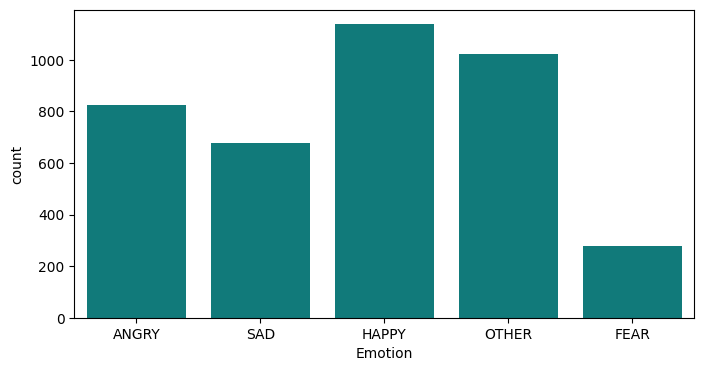

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=train_data, color='darkcyan');

In [8]:
# NULL values
print(train_data.isnull().sum())
print(train_data.duplicated().sum())

index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
print(train_data.shape)

Text       0
Emotion    0
dtype: int64
0
(3939, 2)


In [9]:
# print the rows which duplicated in the text but with different emotions
train_data[train_data['Text'].duplicated() == True]

,Text,Emotion


In [10]:
# Removing duplicated text 
index = train_data[train_data['Text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

In [11]:
# Count the number of stopwords in the data
normalizer = Normalizer()
lemmatizer = Lemmatizer()
persian_stopwords = set(stopwords_list())

temp =train_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

stop_words
3     870
2     774
4     645
1     563
5     412
6     245
0     226
7     118
8      46
9      29
10      9
11      2
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

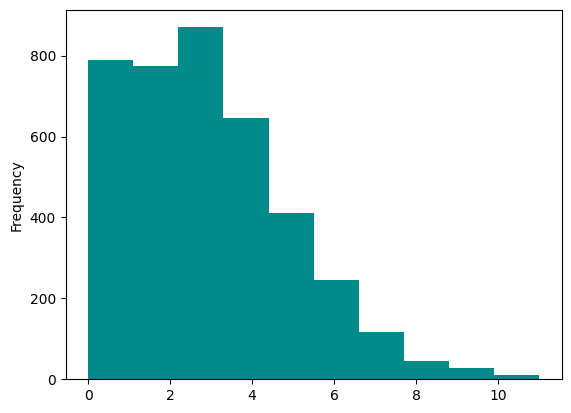

In [12]:
# Distribution of stopwords
temp['stop_words'].plot(kind= 'hist', color="darkCyan")

In [13]:
# Check if the data is balanced or not
test_data.Emotion.value_counts()

Emotion
HAPPY    325
OTHER    242
ANGRY    187
SAD      166
FEAR      65
Name: count, dtype: int64

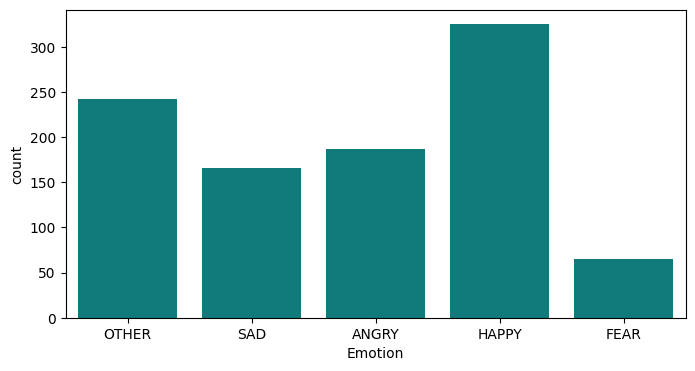

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=test_data, color='darkCyan');

In [15]:
# Number of null values in each column
print(test_data.isnull().sum())
# Number of duplicated values 
print(test_data.duplicated().sum())

Text       0
Emotion    0
dtype: int64
0


In [16]:
test_data[test_data['Text'].duplicated() == True]

,Text,Emotion


In [17]:
temp = test_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

stop_words
3     200
2     197
4     176
1     133
5     108
6      70
0      44
7      33
8      17
9       4
10      2
11      1
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

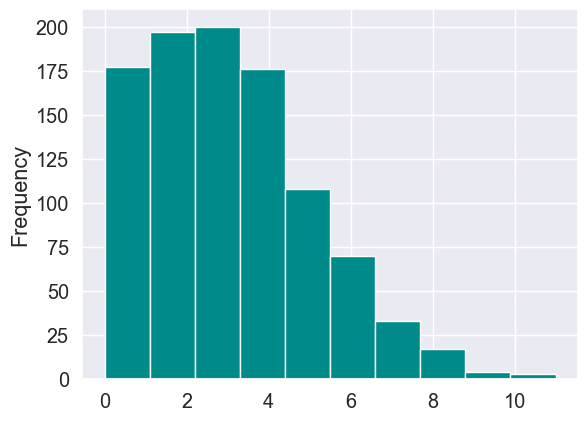

In [18]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist', color="darkCyan")

In [19]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    return diff_df

In [20]:
dataframe_difference(train_data, test_data, which='both')

,Text,Emotion,_merge


## Cleaning

In [21]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
persian_stopwords = set(stopwords_list())

def remove_stop_words(text):
    words = [i for i in str(text).split() if i not in persian_stopwords]
    return " ".join(words)

def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

def to_lower_case(text):
    return " ".join([word.lower() for word in str(text).split()])

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)
    return text.strip()

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def hazm_preprocess(text):
    text = normalizer.decrease_repeated_chars(text)
    text = normalizer.persian_number(text)
    text = normalizer.remove_diacritics(text)
    text = normalizer.correct_spacing(text)
    text = normalizer.normalize(text)
    return text

def hazm_lemmatize(text):
    return lemmatizer.lemmatize(text)

def normalized_sentence(sentence):
    sentence = str(sentence)
    sentence = to_lower_case(sentence)
    sentence = hazm_preprocess(sentence)
    sentence = remove_urls(sentence)
    sentence = remove_punctuations(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_stop_words(sentence)
    sentence = hazm_lemmatize(sentence)
    return sentence

def normalize_text(df):
    df['Text'] = df['Text'].astype(str)
    df['Text'] = df['Text'].apply(to_lower_case)
    df['Text'] = df['Text'].apply(hazm_preprocess)
    df['Text'] = df['Text'].apply(remove_urls)
    df['Text'] = df['Text'].apply(remove_punctuations)
    df['Text'] = df['Text'].apply(remove_numbers)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(hazm_lemmatize)

    return df

def remove_small_sentences(df):
    df['Text'] = df['Text'].apply(lambda x: np.nan if len(str(x).split()) < 3 else x)

In [22]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)

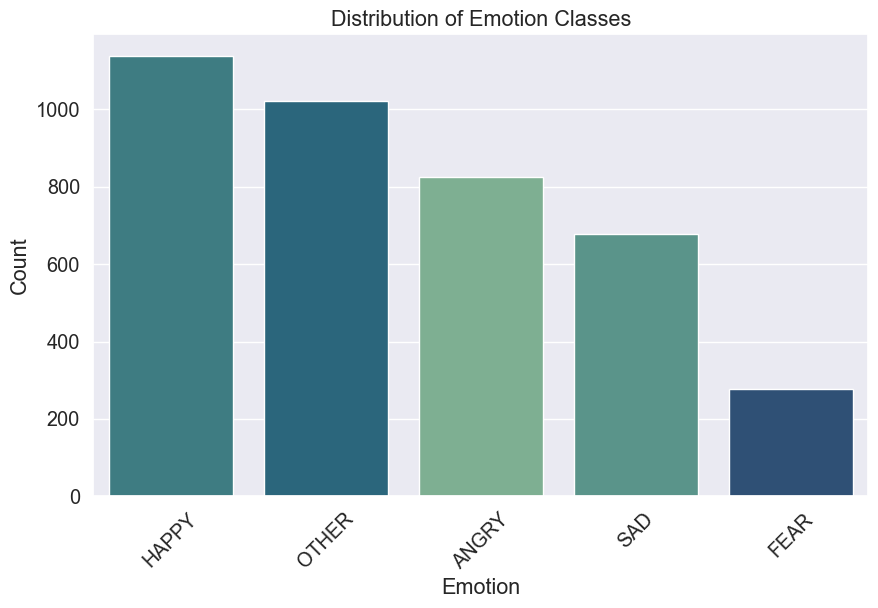

In [23]:
df = train_data 

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Emotion', hue='Emotion', order=df['Emotion'].value_counts().index, palette='crest',legend=False)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [24]:
normalizer = Normalizer()
tokenizer = WordTokenizer()

def preprocess(text):
    text = normalizer.normalize(str(text))
    tokens = tokenizer.tokenize(text)
    return tokens

df['tokens'] = df['Text'].apply(preprocess)


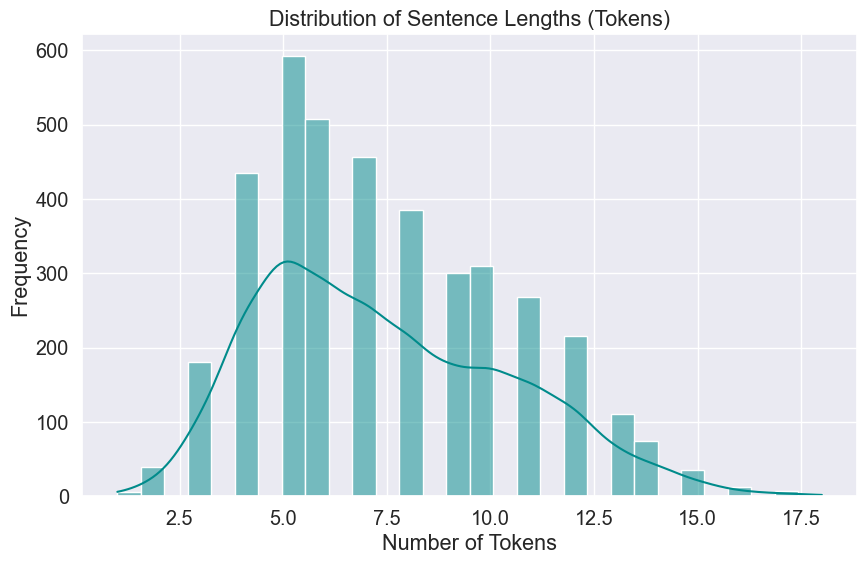

In [25]:
df['text_length'] = df['tokens'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=30, kde=True, color='darkCyan')
plt.title('Distribution of Sentence Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


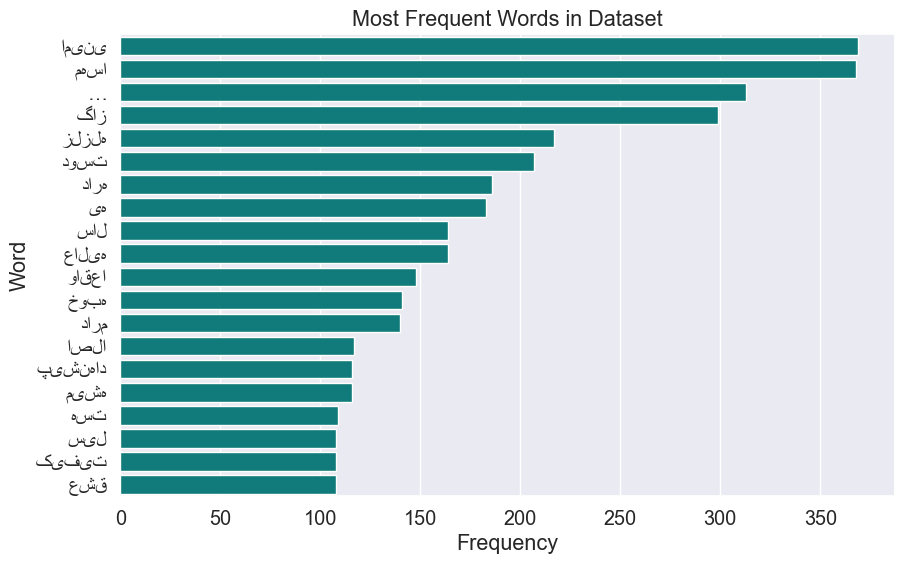

In [26]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
most_common = Counter(all_tokens).most_common(20)

words, freqs = zip(*most_common)
plt.figure(figsize=(10,6))
sns.barplot(x=list(freqs), y=list(words), color='darkCyan',legend=False)
plt.title('Most Frequent Words in Dataset')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


## Modeling

In [27]:
X_train = train_data['Text'].values
y_train = train_data['Emotion'].values

X_test = test_data['Text'].values
y_test = test_data['Emotion'].values

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [29]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [30]:
# Vectorize training data first
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_tfidf, y_train_encoded)

In [31]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    text_clf = Pipeline([
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

In [32]:
def get_F1(true,pred):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Calculate the F1 score for the predictions
    return f1_score(true, pred, average='weighted')

In [33]:
log_reg = train_model(
    LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=0),
    X_train_resampled,
    y_train_resampled
)

X_test_tfidf = tfidf.transform(X_test)

In [34]:
y_pred_lr = log_reg.predict(X_test_tfidf)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test_encoded, y_pred_lr)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_lr = get_F1(y_test_encoded, y_pred_lr)
pd.DataFrame(f1_lr, index=le.classes_, columns=['F1 score'])

Accuracy:  0.550253807106599 



,F1 score
ANGRY,0.559493
FEAR,0.559493
HAPPY,0.559493
OTHER,0.559493
SAD,0.559493


In [35]:
print(classification_report(y_test_encoded, y_pred_lr, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.53      0.48      0.50       187
        FEAR       0.36      0.52      0.42        65
       HAPPY       0.82      0.66      0.74       325
       OTHER       0.47      0.45      0.46       242
         SAD       0.41      0.57      0.48       166

    accuracy                           0.55       985
   macro avg       0.52      0.54      0.52       985
weighted avg       0.58      0.55      0.56       985



In [36]:
X_train_tfidf_orig = tfidf.transform(X_train)

DT = train_model(DecisionTreeClassifier(random_state=0), X_train_tfidf_orig, y_train_encoded)
y_pred_dt = DT.predict(X_test_tfidf)

DT_accuracy =accuracy_score(y_test_encoded, y_pred_dt)
print('Accuracy: ', DT_accuracy,'\n')

f1_dt = get_F1(y_test_encoded, y_pred_dt)
pd.DataFrame(f1_dt, index=le.classes_, columns=['F1 score'])

Accuracy:  0.5218274111675127 



,F1 score
ANGRY,0.517981
FEAR,0.517981
HAPPY,0.517981
OTHER,0.517981
SAD,0.517981


In [37]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_dt, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.45      0.40      0.42       187
        FEAR       0.41      0.35      0.38        65
       HAPPY       0.66      0.72      0.69       325
       OTHER       0.44      0.44      0.44       242
         SAD       0.46      0.46      0.46       166

    accuracy                           0.52       985
   macro avg       0.48      0.47      0.48       985
weighted avg       0.52      0.52      0.52       985



In [38]:
SVM = train_model(SVC(C=1.0, kernel='linear', probability=True,class_weight='balanced'), X_train_tfidf, y_train_encoded)

y_pred_svm = SVM.predict(X_test_tfidf)

SVM_accuracy = accuracy_score(y_test_encoded, y_pred_svm)
print('Accuracy: ', SVM_accuracy,'\n')

f1_Score = get_F1(y_test_encoded, y_pred_svm)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score'])

Accuracy:  0.5634517766497462 



,F1 score
ANGRY,0.57252
FEAR,0.57252
HAPPY,0.57252
OTHER,0.57252
SAD,0.57252


In [39]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_svm, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.50      0.53      0.51       187
        FEAR       0.40      0.58      0.47        65
       HAPPY       0.84      0.65      0.74       325
       OTHER       0.45      0.47      0.46       242
         SAD       0.49      0.56      0.52       166

    accuracy                           0.56       985
   macro avg       0.54      0.56      0.54       985
weighted avg       0.59      0.56      0.57       985



In [40]:
RF =train_model(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

y_pred_rf = RF.predict(X_test_tfidf)

RF_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print('Accuracy: ', RF_accuracy,'\n')

f1_Score = get_F1(y_test_encoded, y_pred_rf)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score']) 

Accuracy:  0.5482233502538071 



,F1 score
ANGRY,0.557681
FEAR,0.557681
HAPPY,0.557681
OTHER,0.557681
SAD,0.557681


In [41]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.49      0.42      0.45       187
        FEAR       0.60      0.57      0.58        65
       HAPPY       0.83      0.62      0.71       325
       OTHER       0.40      0.58      0.48       242
         SAD       0.48      0.50      0.49       166

    accuracy                           0.55       985
   macro avg       0.56      0.54      0.54       985
weighted avg       0.59      0.55      0.56       985



In [42]:
XGB = train_model(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0),X_train_resampled, y_train_resampled)
# xgb_clf.fit()
y_pred_XGB = XGB.predict(X_test_tfidf)
XGB_accuracy = accuracy_score(y_test_encoded, y_pred_XGB)
print('Accuracy: ', XGB_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_XGB)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score']) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:22:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.5350253807106599 



,F1 score
ANGRY,0.543272
FEAR,0.543272
HAPPY,0.543272
OTHER,0.543272
SAD,0.543272


In [43]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_XGB, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.49      0.43      0.46       187
        FEAR       0.52      0.52      0.52        65
       HAPPY       0.79      0.62      0.69       325
       OTHER       0.41      0.53      0.46       242
         SAD       0.44      0.51      0.47       166

    accuracy                           0.54       985
   macro avg       0.53      0.52      0.52       985
weighted avg       0.56      0.54      0.54       985



In [44]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        round(log_reg_accuracy, 2),
        round(DT_accuracy, 2),
        round(SVM_accuracy, 2),
        round(RF_accuracy, 2),
        round(XGB_accuracy, 2)
    ],    'F1 Score (Weighted)': [
        round(get_F1(y_test_encoded, y_pred_lr), 2),
        round(get_F1(y_test_encoded, y_pred_dt), 2),
        round(get_F1(y_test_encoded, y_pred_svm), 2),
        round(get_F1(y_test_encoded, y_pred_rf), 2),
        round(get_F1(y_test_encoded, y_pred_XGB), 2)
    ]
})
models_sorted = models.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
models_sorted


,Model,Accuracy,F1 Score (Weighted)
0,Support Vector Machine,0.56,0.57
1,Logistic Regression,0.55,0.56
2,Random Forest,0.55,0.56
3,XGBoost,0.54,0.54
4,Decision Tree,0.52,0.52


In [45]:
best_model_name = models_sorted.loc[0, 'Model'] 
print("Best model is:", best_model_name)

Best model is: Support Vector Machine


## LIME

In [46]:
idx  = 1
Result_pipeline = make_pipeline(tfidf, XGB.named_steps['clf']) 
pred_label = le.inverse_transform(Result_pipeline.predict([X_test[idx]]))[0]
actual_label = y_test[idx] 

explainer = LimeTextExplainer(class_names=le.classes_)
print("Actual Text : ", X_test[idx])
print("Prediction : ", pred_label)     
print("Actual     : ", actual_label)

exp = explainer.explain_instance(X_test[idx], Result_pipeline.predict_proba, top_labels=5)
exp.show_in_notebook()

Actual Text :  گاز نداریم آب نداریم برق نداریم نت نداریم پول نداریم اعصاب نداریم زندگی نداریم یه دونه فعلا
Prediction :  ANGRY
Actual     :  SAD


## New Modeling

In [47]:
X_train = train_data['Text']
y_train = train_data['Emotion']

X_test = test_data['Text']
y_test = test_data['Emotion']

X_train

0       پست‌تر ادمی ک امیدواهی بهت میده میدونه کارت گی...
1       هست دوست دارم باهاش همصحبت بشم نمیدونم چطوری س...
2                        بالاخره امروز حوصله فوتبال ببینم
3         جوری آهنگ جو میگیرتمو هیچی ازم بعید gt gt gt gt
4                                    خریدش شک نکنید خوشبو
                              ...                        
3934                     نمایندگی زرین قیمت مناسبتری داره
3935            بریم بخوابیم د ارلی برد کچز د ورم شب بخیر
3936    منم جمهوری‌خواه کونی می‌شناسم دلیل می‌شه کونی ...
3937               بی‌کیفیت روزه گارش تموم میشه خراب میشه
3938                               ماندگاری دقیقا ساعت بو
Name: Text, Length: 3939, dtype: object

In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [49]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
print(set(y_train))

{0, 1, 2, 3, 4}


In [50]:
weights = compute_class_weight(class_weight='balanced',
                               classes=np.unique(y_train),
                               y=y_train)

class_weights = dict(enumerate(weights))

sample_weights = np.array([class_weights[i] for i in y_train])

In [51]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Tokenizing

In [52]:
def normalize_persian(text):
    text = re.sub("ي", "ی", text)
    text = re.sub("ك", "ک", text)
    text = re.sub("[ًٌٍَُِّْٰ]", "", text)
    return text.lower()

normalized_text = pd.concat([X_train, X_test], axis=0).apply(normalize_persian)
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(normalized_text)

tokenizer.document_count

4136

In [53]:
tokenizer.texts_to_sequences([X_train.iloc[0]])
tokenizer.texts_to_matrix(X_train[0].split())
tokenizer.texts_to_matrix(X_train[0].split()).shape

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding

In [54]:
test_data.shape

(985, 2)

In [55]:
maxlen = max([len(t) for t in train_data['Text']])
maxlen

93

In [56]:
maxlen = max(len(seq) for seq in sequences_train)

X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 9410


In [57]:
#before
sequences_train[0]

[11, 10, 302, 914, 2084, 25]

In [58]:
#after
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   11,   10,  302,  914, 2084,   25], dtype=int32)

## Word Embedding

In [59]:
import fasttext
from huggingface_hub import hf_hub_download

In [60]:
model_path = hf_hub_download(
    repo_id="taesiri/PersianWordVecs",
    filename="farsi-dedup-cbow.bin"
)
fasttext_model = fasttext.load_model(model_path)

In [61]:
embedding_dim = 100  
vocabSize = len(tokenizer.word_index) + 1  

embedding_matrix = np.zeros((vocabSize, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocabSize:
        continue
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (9410, 100)


In [62]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [63]:
num_tokens = vocabSize
hits=0
misses=0
for word, i in tokenizer.word_index.items():
    if i >= num_tokens:
        continue
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    except:
        misses += 1

print(f"Converted {hits} words ({misses} misses) into embedding vectors.")

Converted 9409 words (0 misses) into embedding vectors.


In [64]:
max_len = 100  

model = Sequential()
model.add(
    Embedding(
        input_dim=vocabSize,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False 
    )
)
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax', kernel_regularizer=l2(0.01)))

adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_m])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       941,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 941,000 (3.59 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 941,000 (3.59 MB)

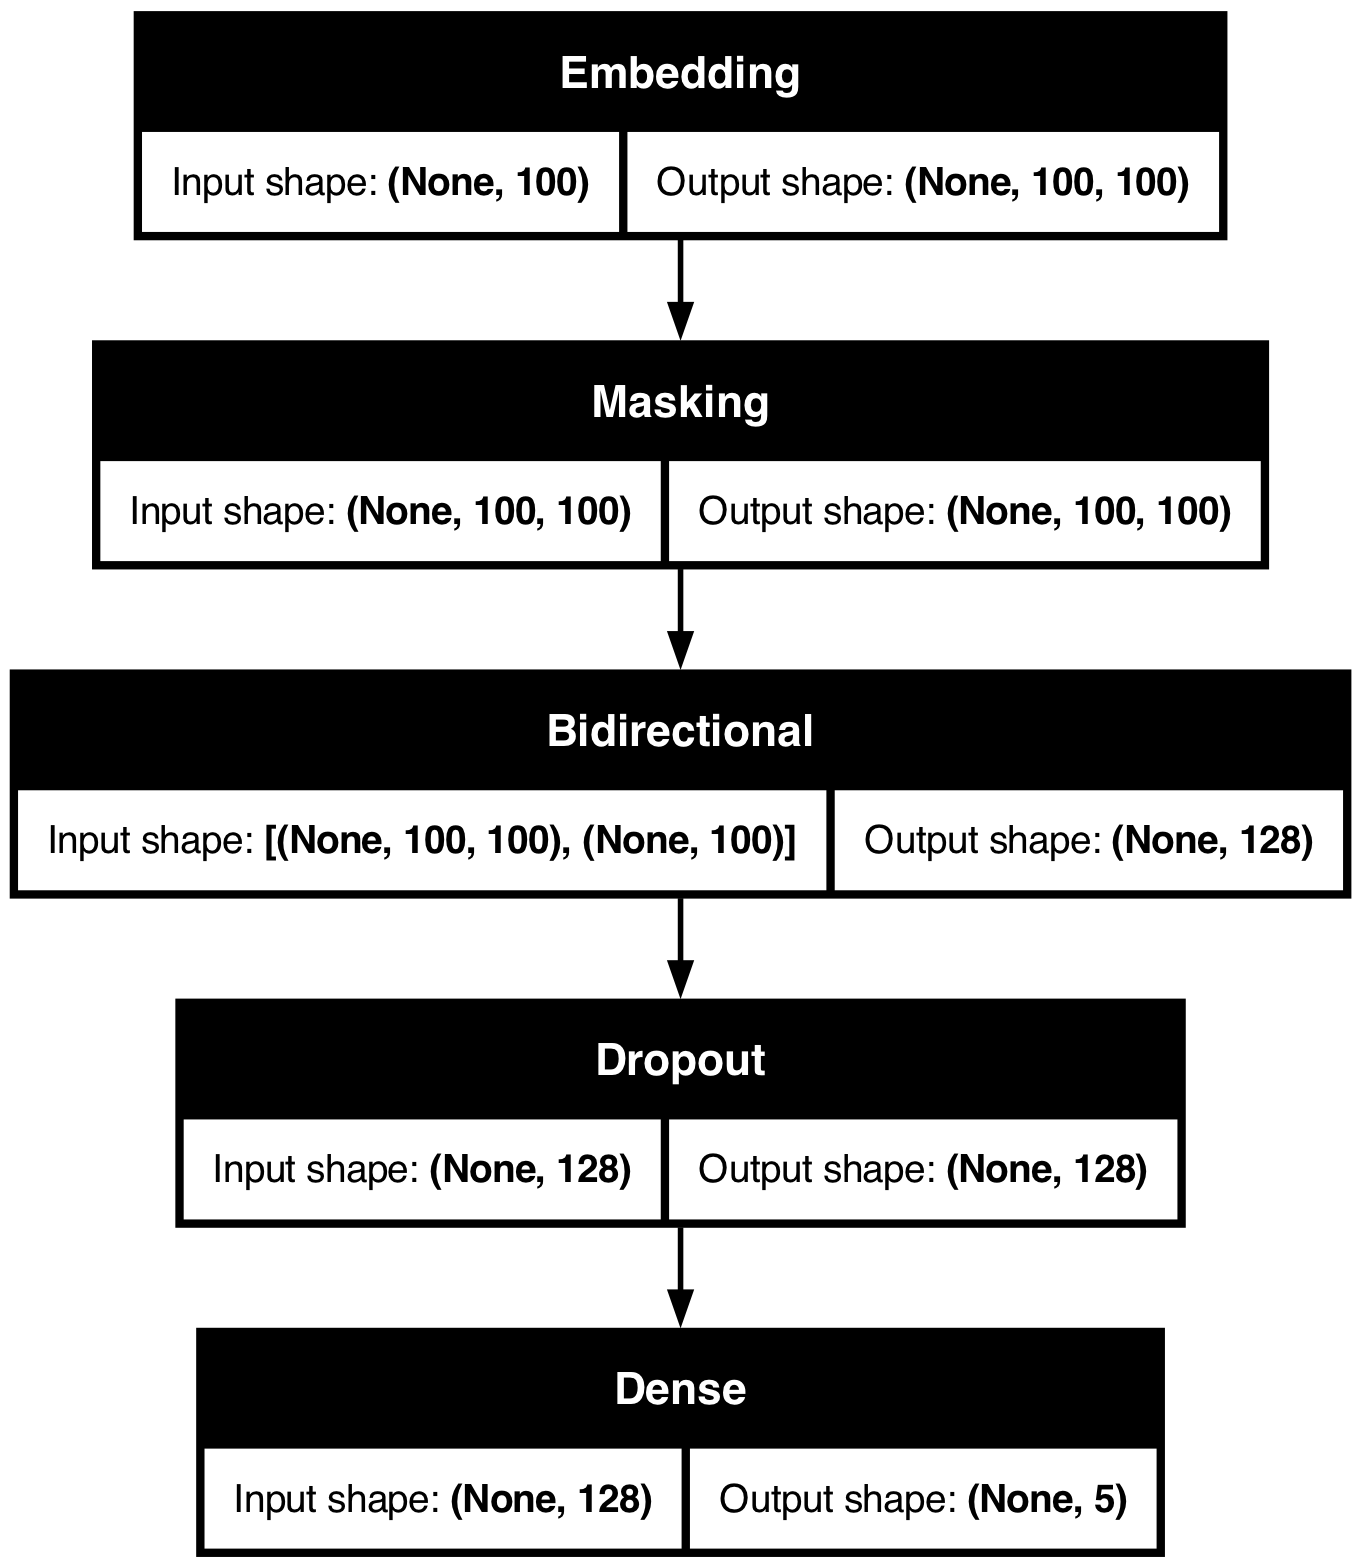

In [65]:
model.build(input_shape=(None, 100))
tf.keras.utils.plot_model(model, show_shapes=True)

In [66]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [67]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  
    callbacks=[callback],
    verbose=1
)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.2972 - f1_m: 0.0960 - loss: 1.6912 - val_accuracy: 0.4632 - val_f1_m: 0.2592 - val_loss: 1.4284
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4548 - f1_m: 0.3002 - loss: 1.4179 - val_accuracy: 0.5368 - val_f1_m: 0.3517 - val_loss: 1.2934
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5098 - f1_m: 0.3919 - loss: 1.2657 - val_accuracy: 0.5596 - val_f1_m: 0.4249 - val_loss: 1.2215
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5568 - f1_m: 0.4526 - loss: 1.1934 - val_accuracy: 0.5558 - val_f1_m: 0.4741 - val_loss: 1.1883
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5709 - f1_m: 0.4963 - loss: 1.1157 - val_accuracy: 0.5635 - val_f1_m: 0.4890 - val_loss: 1.1668
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5958 - f1_m: 0.5331 - loss: 1.0687 - val_accuracy: 0.5761 - val_f1_m: 0.5071 - val_loss: 1.1568
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━

In [68]:
#Overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5755 - f1_m: 0.5281 - loss: 1.1131


[1.0828012228012085, 0.5951776504516602, 0.5457929372787476]

In [69]:
#Overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6030 - f1_m: 0.5778 - loss: 1.0468


[1.0653550624847412, 0.5928934216499329, 0.5650045871734619]

In [70]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(test_data['Emotion']), y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step
              precision    recall  f1-score   support

           0       0.49      0.55      0.52       187
           1       0.36      0.49      0.41        65
           2       0.85      0.71      0.77       325
           3       0.50      0.47      0.48       242
           4       0.56      0.63      0.59       166

    accuracy                           0.59       985
   macro avg       0.55      0.57      0.56       985
weighted avg       0.61      0.59      0.60       985



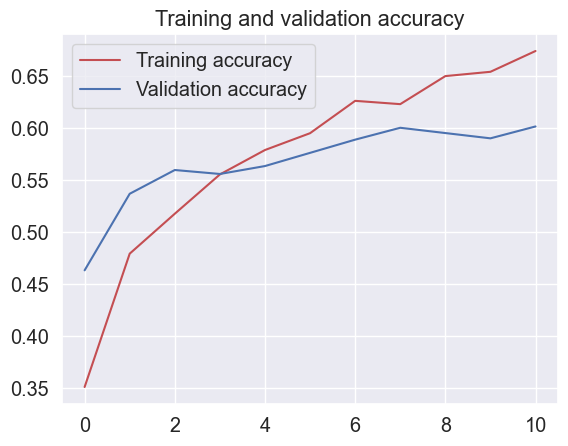

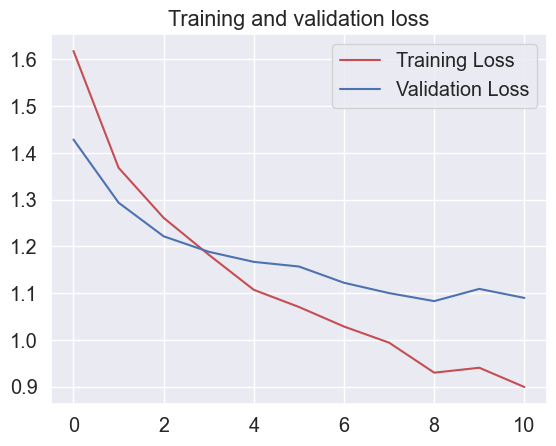

In [71]:
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [72]:
# Classify custom sample
sentences = [
             "با اینکار خوشحال شدم",
            "اه تف به این زندگی",
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

با اینکار خوشحال شدم
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
HAPPY : 0.350850373506546


اه تف به این زندگی
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
OTHER : 0.6683528423309326


